# CSX46 Class Notebook 3 - Degree Distribution

In this class session we are going to plot the degree distribution of the undirected human
protein-protein interaction network (PPI). We will do this without using `igraph`, although as we will learn, `igraph` does have a function for fitting a power law to the empirical degree distribution of a network. We'll obtain the interaction data from the Pathway Commons SIF file (see Class Session 1 notebook) and we'll
manually compute the degree of each vertex (protein) in the network. We'll then compute
the count *N(k)* of vertices that have a given vertex degree *k*, for all *k* values.
Finally, we'll plot the degree distribution and discuss whether it is consistent with the
results obtained in the Jeong *et al.* article for the yeast PPI.  

We'll start by loading all of the Python modules that we will need for this notebook.  Because we'll be calling a bunch of functions from `numpy` and `matplotlib.pyplot`, we'll alias these packages as `np` and `plt`, respectively.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

We are also going to need igraph

In [4]:
!pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 48.8 MB/s eta 0:00:00


In [5]:
import igraph as ig

Download the Pathway Commons 2 SIF file and uncompress it (see Part 2 of the notebook from Class Session 1)

In [6]:
!wget https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz
!gunzip -f PathwayCommons9.All.hgnc.sif.gz

--2026-01-13 03:18:12--  https://csx46.s3-us-west-2.amazonaws.com/PathwayCommons9.All.hgnc.sif.gz
Resolving csx46.s3-us-west-2.amazonaws.com (csx46.s3-us-west-2.amazonaws.com)... 3.5.77.24, 3.5.77.158, 3.5.85.117, ...
Connecting to csx46.s3-us-west-2.amazonaws.com (csx46.s3-us-west-2.amazonaws.com)|3.5.77.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6072823 (5.8M) [binary/octet-stream]
Saving to: ‘PathwayCommons9.All.hgnc.sif.gz’

PathwayCommons9.All 100%[===================>]   5.79M  9.26MB/s    in 0.6s    

2026-01-13 03:18:13 (9.26 MB/s) - ‘PathwayCommons9.All.hgnc.sif.gz’ saved [6072823/6072823]



Load in the SIF file as a `pandas` data frame using `pandas.read_csv`.  Make sure the column names of your data frame are `species1`, `interaction_type`, and `species2`. Save the data frame as the object `sif_data`.

In [7]:
import pandas as pd
import csv
sif_data = pd.read_csv("PathwayCommons9.All.hgnc.sif",
                     sep="\t",
                     quoting=csv.QUOTE_NONE,
                     names=["species1", "interaction_type", "species2"])

sif_data.columns

Index(['species1', 'interaction_type', 'species2'], dtype='object')

Step 2:  restrict the interactions to protein-protein undirected ("in-complex-with", "interacts-with"). The restricted data frame should be called `interac_ppi`. Then we will make a copy using `copy` so `interac_ppi` is independent of `sif_data` which will be convenient for this exercise.

In [8]:
interaction_types_ppi = set(["interacts-with",
                             "in-complex-with"])
interac_ppi = sif_data[sif_data.interaction_type.isin(interaction_types_ppi)].copy()

Step 3: for each interaction, reorder `species1` and `species2` (if necessary) so that
`species1 < species2` (in terms of the species names, in lexicographic order).  You can make a boolean vector `boolean_vec` containing (for each row of the data frame `interac_ppi`) `True` if `species2 > species1` (by [lexicographic order](https://stackoverflow.com/questions/45950646/what-is-lexicographical-order)) for that row, or `False` otherwise.  You can then use the `loc` method on the data frame, to select rows based on `boolean_vec` and the two columns that you want (`species1` and `species2`). [Thanks to Garrett Bauer for suggesting this approach, which is more elegant than looping over all rows]:

In [9]:
boolean_vec = interac_ppi['species1'] > interac_ppi['species2']
interac_ppi.loc[boolean_vec, ['species1', 'species2']] = interac_ppi.loc[boolean_vec, ['species2', 'species1']].values

Since `for` loops are reasonably fast in Python (at least, compared to in R), you could also do this using a `for` loop through all of the rows of the data frame, swapping `species1` and `species2` entries as needed (and in-place in the data frame) so that in the resulting data frame `interac_ppi` satisfies `species1 < species2` for all rows.

In [10]:
for rowid, row in interac_ppi.head().iterrows():
    if row['species1'] > row['species2']:
        interac_ppi['species1'][rowid] = row['species2']
        interac_ppi['species2'][rowid] = row['species1']

Step 4: Restrict the data frame to only include the columns `species1` and `species2`. Use the `pandas.DataFrame.drop_duplicates` method to subset the rows of the resulting two-column data frame to only unique rows. Assign the resulting data frame object to have the name `interac_ppi_unique`.  This is basically selecting only unique pairs of proteins, regardless of interaction type.

In [11]:
interac_ppi_unique = interac_ppi.loc[:,['species1', 'species2']].drop_duplicates()

Step 5: compute the degree of each vertex (though we will not associate the vertex degrees with vertex names here, since for this exercise we only need the vector of vertex degree values, not the associated vertex IDs).  You'll want to create an object called `vertex_degrees_ctr` which is of class `collections.Counter`.  You'll want to name the final list of vertex degrees, `vertex_degrees`.

In [12]:
import collections
allproteins = interac_ppi_unique["species1"].tolist() + interac_ppi_unique["species2"].tolist()
vertex_degrees_ctr = collections.Counter(allproteins)
vertex_degrees = list(vertex_degrees_ctr.values())

Let's print out the vertex degrees of the first 10 vertices, in whatever the key order is. Pythonistas -- anyone know of a less convoluted way to do this?  (I did it by wrapping a `dict` around `vertex_degrees_ctr`, and then calling the `items` method, and then passing that to a list and then subsetting the list to the first 10 elements, and then finally wrapping another `dict` around that list).

In [13]:
dict(list(dict(vertex_degrees_ctr).items())[0:9])

{'A1BG': 59,
 'A1CF': 34,
 'A2M': 171,
 'A2ML1': 4,
 'A4GALT': 6,
 'A4GNT': 19,
 'AAAS': 72,
 'AACS': 6,
 'AADAC': 2}

Let's print out the first ten entries of the `vertex_degrees` list.  Note that we don't expect it to be in the same order as the output from the previous command above, since `dict` changes the order in the above.

In [14]:
print(vertex_degrees[0:9])

[59, 34, 171, 4, 6, 19, 72, 6, 2]


Step 6: Calculate the histogram of *N(k)* vs. *k*, using 30 bins, using `plt.hist`.  You'll probably want to start by making a `numpy.array` from your `vertex_degrees`.  Name the resulting object from calling `plt.hist`, `hist_res`. Obtain a numpy array of the bin counts as element zero from `hist_res` (name this object `hist_counts`) and obtain a numpy array of the bin centers (which are *k* values) as element one from `hist_res` (name this object `hist_breaks`). Finally, you want the *k* values of the centers of the bins, not the breakpoint values. So you'll have to do some arithmetic to go from the 31 *k* values of the bin breakpoints, to a numpy array of the 30 *k* values of the centers of the bins.  You should call that object `kvals`.

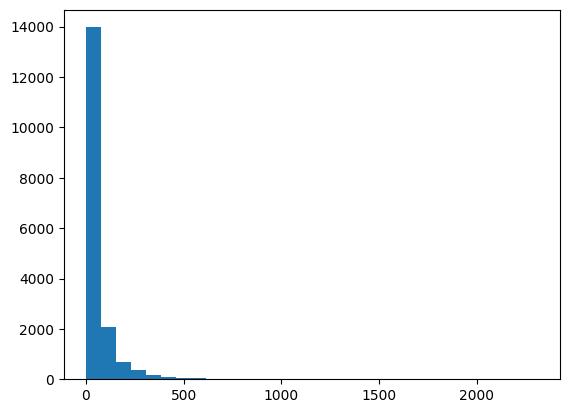

In [15]:
nbins = 30
hist_res = plt.hist(np.array(vertex_degrees), bins= nbins)
hist_counts = hist_res[0]
hist_breaks = hist_res[1]
kvals = 0.5*(hist_breaks[0:(nbins)] + hist_breaks[1:(nbins+1)])

Let's print the *k* values of the bin centers:

In [16]:
print(kvals)

[  39.48333333  116.45        193.41666667  270.38333333  347.35
  424.31666667  501.28333333  578.25        655.21666667  732.18333333
  809.15        886.11666667  963.08333333 1040.05       1117.01666667
 1193.98333333 1270.95       1347.91666667 1424.88333333 1501.85
 1578.81666667 1655.78333333 1732.75       1809.71666667 1886.68333333
 1963.65       2040.61666667 2117.58333333 2194.55       2271.51666667]


Let's print the histogram bin counts:

In [17]:
print(hist_counts)

[1.3975e+04 2.0580e+03 7.0200e+02 3.6300e+02 1.8000e+02 1.0200e+02
 4.5000e+01 5.9000e+01 1.3000e+01 8.0000e+00 8.0000e+00 1.0000e+00
 1.0000e+00 5.0000e+00 2.0000e+00 2.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 0.0000e+00
 1.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]


Step 7: Plot `N(k)` vs. `k`, on log-log scale (using only the first 14 points, which is plenty sufficient to see the approximatey scale-free degree distribution and where it becomes exponentially suppressed at high `k`.  For this you'll use `plt.loglog`.  You'll probably want to adjust the x-axis limits using `plt.gca().set_xlim()`.  To see the plot, you'll have to do `plt.show()`.

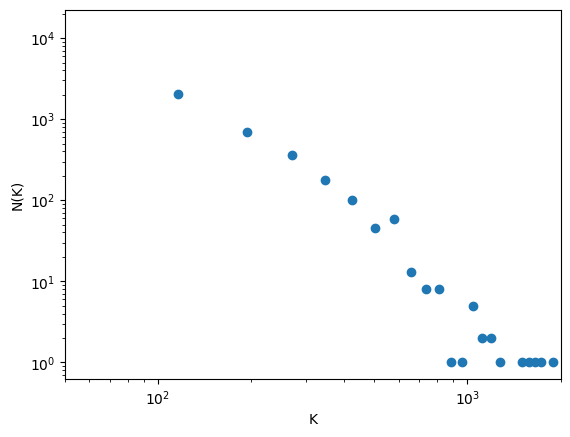

In [18]:
inds = np.where(hist_counts > 0)
plt.loglog(kvals[inds], hist_counts[inds], "o")
plt.xlabel("K")
plt.ylabel("N(K)")
plt.gca().set_xlim([50, 2000])
plt.show()

Step 8:  Do a linear fit to the log10(N(k)) vs. log10(k) data (just over the bins where the count is nonzero).  You'll want to use `scipy.stats.linregress` to do the linear regression.  Don't forget to log10-transform the data using `np.log10`.

In [19]:
import scipy
fit = scipy.stats.linregress(np.log10(kvals[inds]), np.log10(hist_counts[inds]))
print(fit)

LinregressResult(slope=np.float64(-2.8404237326119177), intercept=np.float64(9.1344087210706), rvalue=np.float64(-0.9669930870015452), pvalue=np.float64(6.014754458564446e-14), stderr=np.float64(0.16332549645288855), intercept_stderr=np.float64(0.46829803380434365))


Slope estimate is -2.8.

Now let's compute the slope for the degree distribution Fig. 1b in the Jeong et al. article, for the yeast PPI.  The change in ordinate over the linear range is about -6.5 in units of natural logarithm. The change in abscissa over the linear range is approximately log(45)-log(2), so we can compute the Jeong et al. slope thus:

In [20]:
jeong_slope = -6.5/(np.log(45)-np.log(2))
print("%.2f" % jeong_slope)

-2.09


How close was your slope from the human PPI, to the slope for the yeast PPI from the Jeong et al. article?

As stated above, `igraph` has a built-in function for computing the degree distribution and another built-in function for fitting a line to the log-log degree distribution. Let's try them out, doing the same analysis that we did above, but using the `igraph` functions.

First, let's make an `igraph.Graph` object using `igraph.Graph.TupleList` and providing the edge-list obtained from calling the `tolist` method on `interact_ppi_unique`. Make sure to specify `directed=False` when you are making the `igraph.Graph` object.

In [25]:
g = ig.Graph.TupleList(interac_ppi_unique.values.tolist(), directed=False)

As usual, we should look at the "summary" of the graph

In [26]:
ig.Graph.summary(g)

'IGRAPH UN-- 17531 475553 -- \n+ attr: name (v)'

Now call the `degree_distribution` method on the graph object, which returns an object of class `igraph.statistics.Histogram`. Now call the `bins` method on the histogram object. It returns an iterable (specifically, an object of type `generator`), and if you iterate over it using a `for` loop, it will return a tuple (containing three values) for each bin. Grab the first and third item from each tuple; those are the left *k* value of the bin and the bin count, respectively. Break them out into separate vectors (of length equal to the number of bins) `xs` and `ys`, respectively. Plot `ys` vs. `xs` on log-log scale using `matplotlib.pyplot.loglog`.

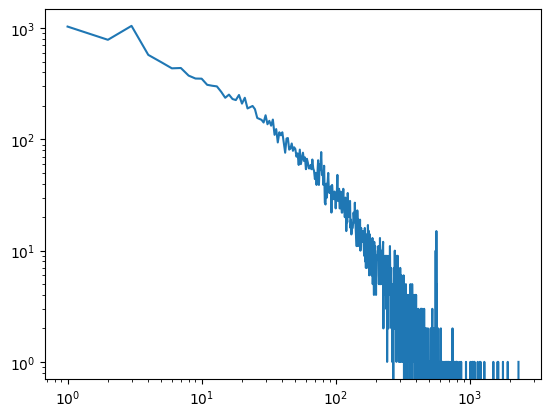

In [27]:
xs, ys = zip(*[(left, count) for left, _, count in
         g.degree_distribution().bins()])
plt.loglog(xs, ys)
plt.show()

Get the degrees of all the nodes by calling the `degree` method on the `igraph.Graph` object `g`. Pass that object to `igraph.statistics.power_law_fit` and print the result.

In [30]:
ig.statistics.power_law_fit(g.degree())

FittedPowerLaw(continuous=False, alpha=3.4817712589157335, xmin=245.0, L=-4321.089453205786, D=0.049832437579329425, p=0.0)

## Computing and plotting the network degree distribution, as a bash one-liner

First, we'll need to install `gnuplot` and `imagemagick`, using `apt-get`

In [31]:
! apt-get install -y gnuplot imagemagick >/dev/null

Extracting templates from packages: 100%


OK, here is how to do it in a single bash command:

In [32]:
! egrep $'\tinteracts-with\t|\tin-complex-with\t' PathwayCommons9.All.hgnc.sif  | \
 cut -f1,3 | \
 sed 's/\t/\n/g' | \
 sort | \
 uniq -c | \
 sort -k1nr | \
 sed 's/^\s*//g' | \
 cut -f1 -d\  | \
 awk '{print int(int($1)/100)}' | \
 sort | \
 uniq -c | \
 awk 'BEGIN { print "set term png\nset out\nplot '\''<cat'\''"} { print $2 "\t" log($1)/log(10)}' | \
 gnuplot -p > degdist.png

The following code is necessary to display a PNG image in Google Colab (in Jupyter, the PNG binary stream can be piped directly to the built-in shell function `display`, so python code is not needed if we were doing this in Jupyter).

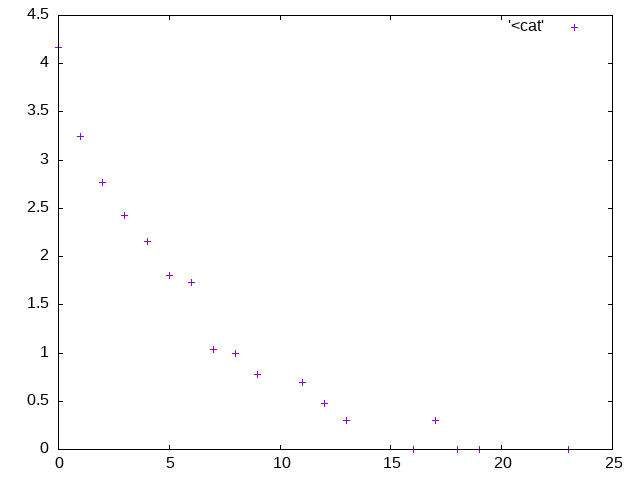

In [33]:
from IPython.display import Image
Image('degdist.png')